# Matrix weight
This is to explore the higher characteristic dimension. 

In [1]:
# %%
import numpy as np
import pandas as pd
# import igraph as ig
import networkx as nx

# 3D plot
from mpl_toolkits import mplot3d

## Functions

In [2]:
# Generate rotation matrices
from itertools import combinations

def generate_random_rotation_matrix(k):
    A = np.eye(k)
    planes = list(combinations(range(k), 2))
    np.random.shuffle(planes)
    for i, j in planes:
        val = np.random.uniform(-1, 1)
        th = val * np.pi
        print("planes: ({}, {}), angle: {} pi".format(i,j,val))
        R = np.eye(k)
        R[i, i] = np.cos(th)
        R[i, j] = -np.sin(th)
        R[j, i] = np.sin(th)
        R[j, j] = np.cos(th)
        A = R @ A
    return A

In [3]:
def generate_rotation_noise_matrix(k, noise=0.):
    A = np.eye(k)
    planes = list(combinations(range(k), 2))
    np.random.shuffle(planes)
    for i, j in planes:
        val = np.random.normal(scale=noise)
        th = val * np.pi
        print("planes: ({}, {}), noise angle: {} pi".format(i,j,val))
        R = np.eye(k)
        R[i, i] = np.cos(th)
        R[i, j] = -np.sin(th)
        R[j, i] = np.sin(th)
        R[j, j] = np.cos(th)
        A = R @ A
    return A

In [4]:
def assign_rotation_matrix(src, trg):
    k, l = membership[src], membership[trg]
    if np.random.rand() < coherence:
        return com_com_rotation_matrix[(k, l)] # assign the community to community matrix
    else:
        return generate_rotation_noise_matrix(k=dim, noise=noise).dot(com_com_rotation_matrix[(k, l)])

## Consensus

### n_communities = 2

In [5]:
# Parameters
n_nodes = 80
n_communities = 2
pin, pout = 0.3, 0.3

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities

In [6]:
g = nx.stochastic_block_model(block_sizes, pref_matrix, seed=0, directed=False)
A = nx.to_scipy_sparse_array(g)

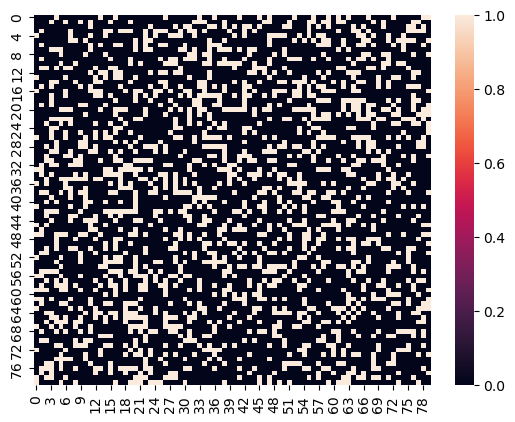

In [7]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [8]:
# Sanity check
dim = 3

R = generate_random_rotation_matrix(k=dim)
assert np.all(np.isclose(R.T @ R, np.eye(dim))), "R is not orthonormal"

planes: (0, 1), angle: 0.23292402982762295 pi
planes: (0, 2), angle: -0.4336825946599876 pi
planes: (1, 2), angle: -0.02840871658455013 pi


In [9]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [10]:
# inital characteristic vector for nodes
# s1 - choose a random position, and assign to nodes in one community
y_0_2d = np.random.rand(dim)
y_0_2d /= np.linalg.norm(y_0_2d)
print(y_0_2d)

[0.48243642 0.26995353 0.83329478]


In [11]:
# randomly assign a few nodes with nonzero characteristics at t=0
from random import sample

n_sel = [15, 20][1]
nodes_0 = sample(range(block_sizes[0]), n_sel)

In [12]:
row = []
col = [0]*(n_sel*dim)
data = []
for k in nodes_0:
    for ki in range(dim):
        row.append(k*dim+ki)
        data.append(y_0_2d[ki])

In [13]:
from scipy.sparse import csr_array, csc_matrix
y_0 = csc_matrix((data, (row, col)), shape=(n_nodes*dim, 1))

In [14]:
# Generate a set of random rotations for each pair of communities
from scipy import sparse

src, trg, _ = sparse.find(sparse.triu(A, 1)) # only edges
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

In [15]:
noise = 0.

# intially balanced configuration
# internal edges - identity matrix
com_com_rotation_matrix = {(l, l): np.eye(dim) for l in range(n_communities)}
# external edges - first path random
com_com_rotation_matrix.update({(l, l+1): generate_random_rotation_matrix(k=dim) for l in range(n_communities-1)})
# external edges - others by existing ones
if n_communities == 2:
    com_com_rotation_matrix[(1,0)] = com_com_rotation_matrix[0,1].T

planes: (0, 2), angle: 0.41174483434518017 pi
planes: (0, 1), angle: 0.33025935210412904 pi
planes: (1, 2), angle: -0.1660601298243869 pi


In [16]:
coherence = 1.
# noise = 0.

In [17]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

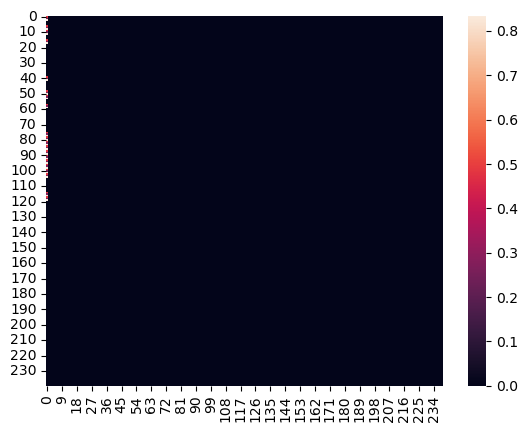

In [18]:
sns.heatmap(A_mat.todense())
plt.show()

In [19]:
# Laplacian
L_mat = D_mat - A_mat

In [20]:
# theoretical results
mat = y_0.toarray().reshape(n_nodes, dim)
y_0_bar = np.sum([assign_rotation_matrix(0, k).dot(mat[k, :]) for k in range(n_nodes)], axis=0)

y_star = []
for c in range(n_communities):
    y_star.append(com_com_rotation_matrix[(0, c)].T.dot(y_0_bar)/n_nodes)
# y_1 = com_com_rotation_matrix[(0, 0)].dot(y_0_bar)/n_nodes
# y_2 = com_com_rotation_matrix[(0, 1)].T.dot(y_0_bar)/n_nodes
print("C1:", y_star[0])
print("C2:", y_star[1])

C1: [0.1206091  0.06748838 0.2083237 ]
C2: [ 0.21216459 -0.12689469  0.03720112]


In [21]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

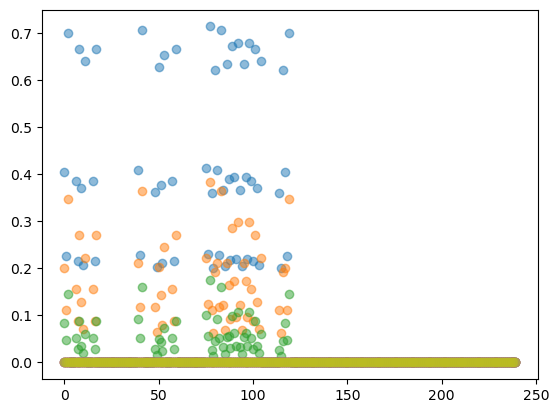

In [22]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

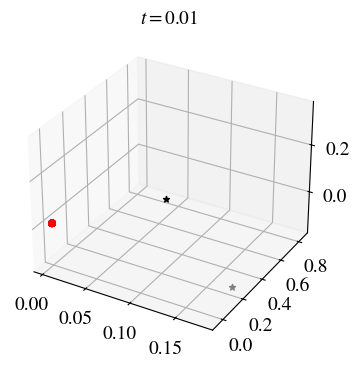

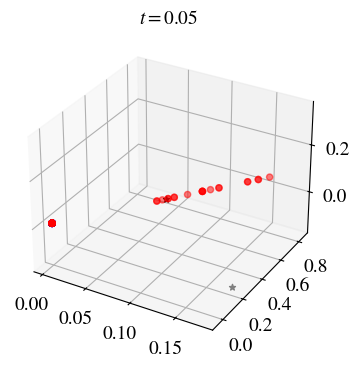

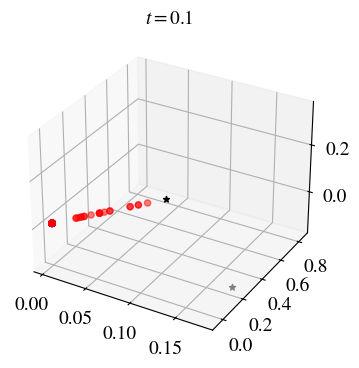

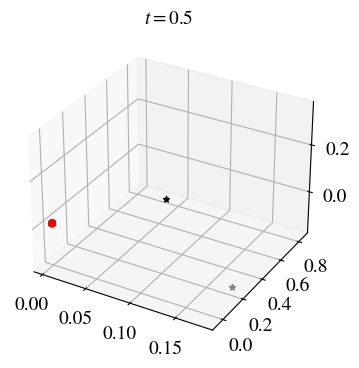

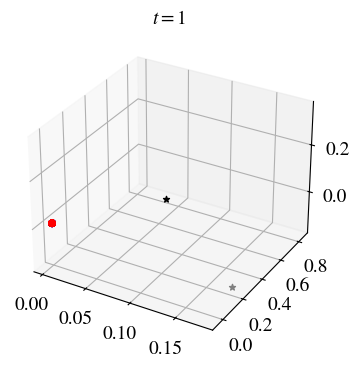

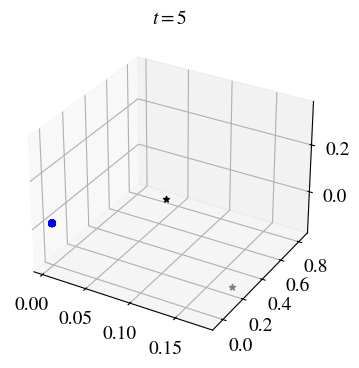

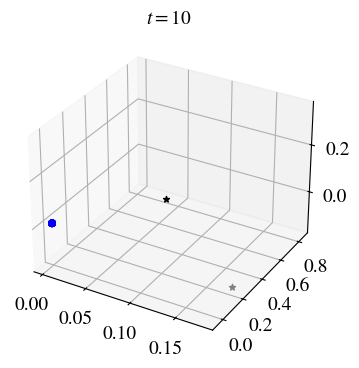

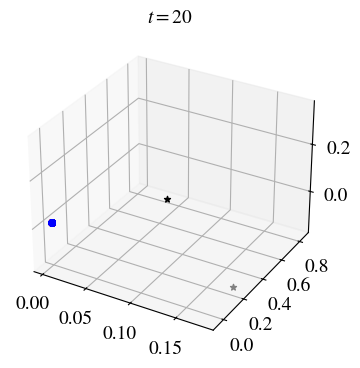

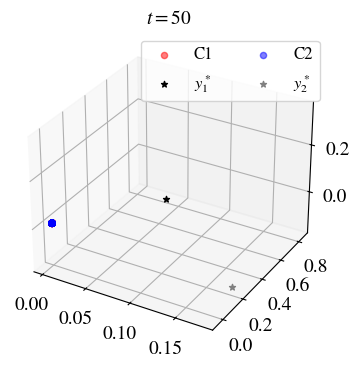

In [23]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.01, 0.19])
    ax.set_ylim([-0.1, 0.9])
    ax.set_zlim([-0.18, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=2, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
#

#### Adding some noise

In [24]:
coherence = .8
noise = 0.1

In [25]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 1), noise angle: -0.012149979242012734 pi
planes: (1, 2), noise angle: 0.09357261530910667 pi
planes: (0, 2), noise angle: -0.02330865244879081 pi
planes: (0, 2), noise angle: -0.009524394357651388 pi
planes: (0, 1), noise angle: -0.14609220911090007 pi
planes: (1, 2), noise angle: -0.004312526905909247 pi
planes: (0, 2), noise angle: -0.1449746028912284 pi
planes: (1, 2), noise angle: -0.09974392032832768 pi
planes: (0, 1), noise angle: 0.03663010688400666 pi
planes: (0, 2), noise angle: 0.04051580095675733 pi
planes: (0, 1), noise angle: -0.16118594086705096 pi
planes: (1, 2), noise angle: -0.02653823187280854 pi
planes: (0, 2), noise angle: -0.028663630900251348 pi
planes: (0, 1), noise angle: -0.045833654126423526 pi
planes: (1, 2), noise angle: -0.1530666855215188 pi
planes: (0, 2), noise angle: 0.17286439517873298 pi
planes: (0, 1), noise angle: 0.03610510926991014 pi
planes: (1, 2), noise angle: 0.2559280332748047 pi
planes: (0, 2), noise angle: -0.023127801523367172

In [26]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

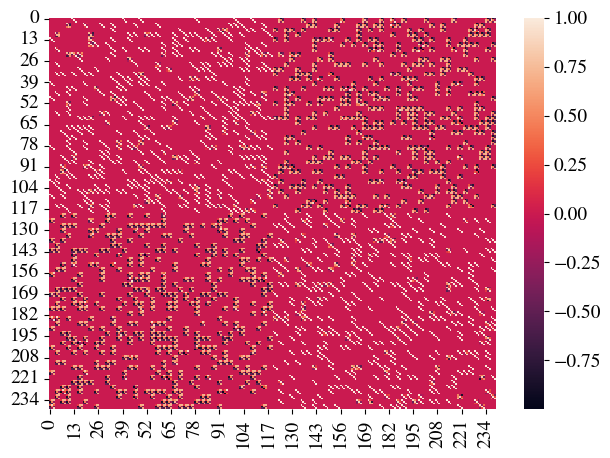

In [27]:
sns.heatmap(A_mat.todense())
plt.show()

In [28]:
# Laplacian
L_mat = D_mat - A_mat

In [29]:
# consensus dynamics
from scipy.sparse.linalg import expm

ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

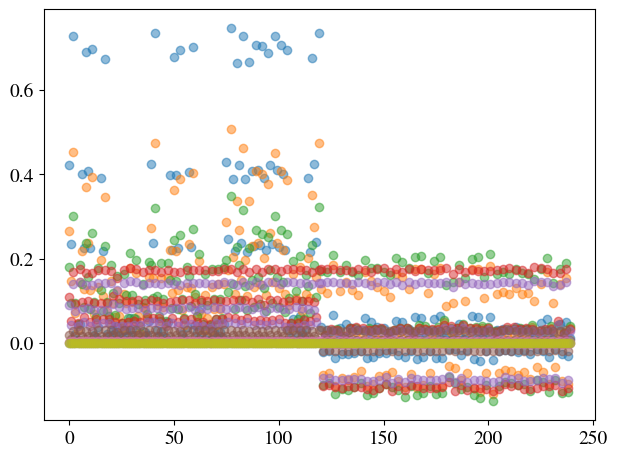

In [30]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

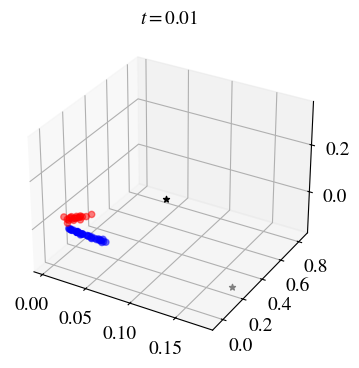

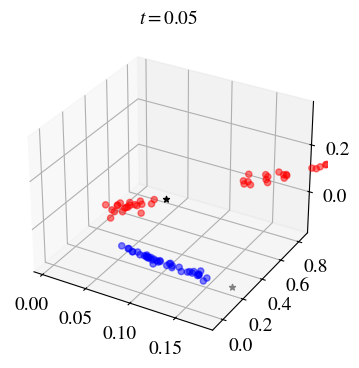

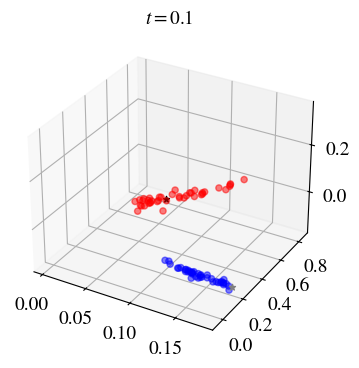

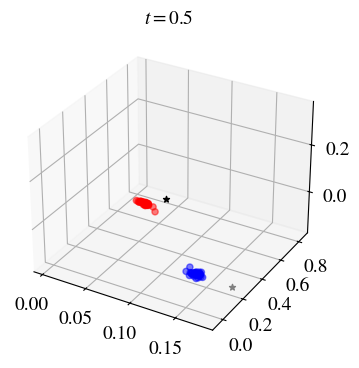

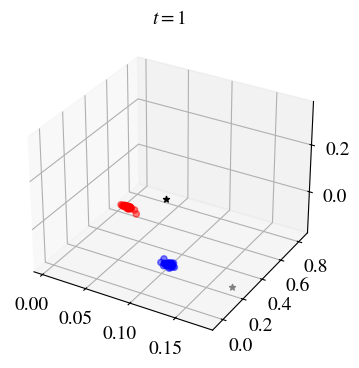

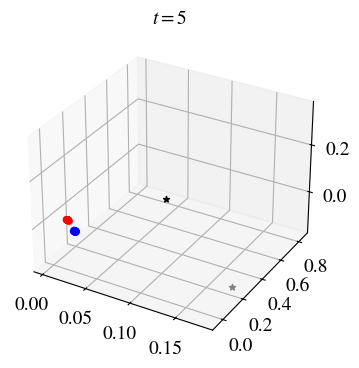

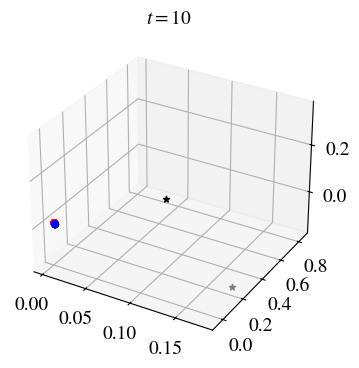

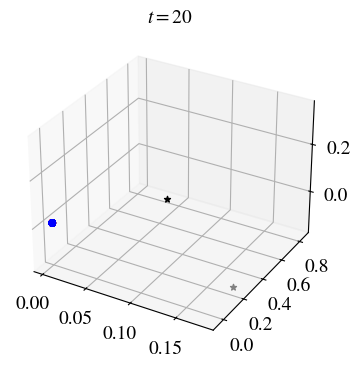

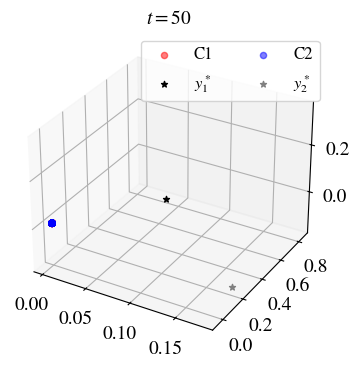

In [31]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.01, 0.19])
    ax.set_ylim([-0.1, 0.9])
    ax.set_zlim([-0.18, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=2, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
#

#### Reducing p_out

In [32]:
# randomly remove edges from g
pout2 = [0.1, 0.03, 0.01][0]
pcut = (pout - pout2)/pout
print("edges to cut:", pcut)

edges to cut: 0.6666666666666666


In [33]:
g2 = g.copy()
edges_out = [(k,l) for k,l in zip(src, trg) if membership[k] != membership[l]]
print("#edges out:", len(edges_out))
n_cut = int(len(edges_out)*pcut)
print("#edges to cut", n_cut)

#edges out: 468
#edges to cut 312


In [34]:
from random import sample

ind_cut = sample(range(len(edges_out)), n_cut)
edges_cut = [edges_out[k] for k in ind_cut]
g2.remove_edges_from(edges_cut)

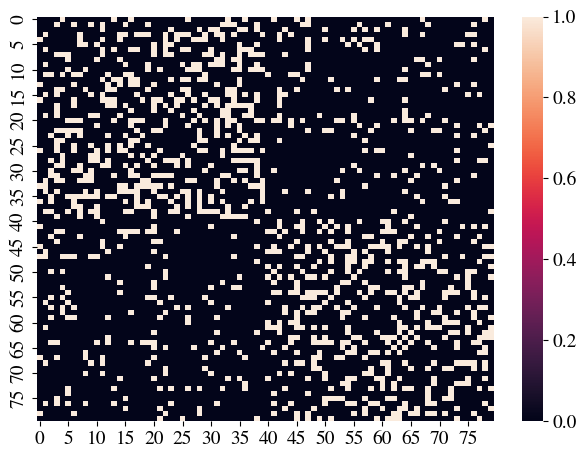

In [35]:
A = nx.to_scipy_sparse_array(g2)
sns.heatmap(A.todense())
plt.show()

In [36]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [37]:
src2, trg2, _ = sparse.find(sparse.triu(A, 1)) # only edges

In [38]:
coherence = .8
noise = 0.1

In [39]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src2, trg2):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (1, 2), noise angle: -0.013275509266326202 pi
planes: (0, 1), noise angle: -0.10443262778357215 pi
planes: (0, 2), noise angle: 0.04001025622577086 pi
planes: (1, 2), noise angle: -0.14947950510672525 pi
planes: (0, 2), noise angle: -0.004589368927096348 pi
planes: (0, 1), noise angle: -0.03271053846349583 pi
planes: (1, 2), noise angle: 0.0229617041734525 pi
planes: (0, 2), noise angle: 0.11723652334167217 pi
planes: (0, 1), noise angle: -0.09186831750877847 pi
planes: (1, 2), noise angle: -0.07837993797509527 pi
planes: (0, 1), noise angle: -0.023365544995585817 pi
planes: (0, 2), noise angle: -0.2437958446228949 pi
planes: (0, 1), noise angle: 0.09047897468835689 pi
planes: (1, 2), noise angle: -0.05081364573014905 pi
planes: (0, 2), noise angle: 0.0016763311730582605 pi
planes: (0, 2), noise angle: -0.2005886534619804 pi
planes: (0, 1), noise angle: -0.006247364255113351 pi
planes: (1, 2), noise angle: -0.14212350282663289 pi
planes: (0, 2), noise angle: 0.04271555604078572

In [40]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

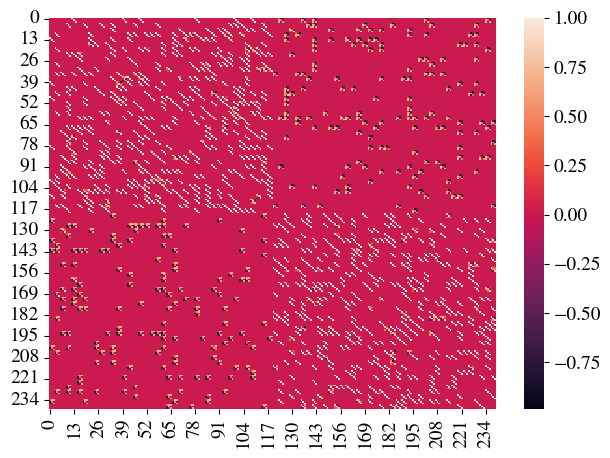

In [41]:
sns.heatmap(A_mat.todense())
plt.show()

In [42]:
# Laplacian
L_mat = D_mat - A_mat

In [43]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
# ts = np.arange(1.6, 3., 0.1)
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

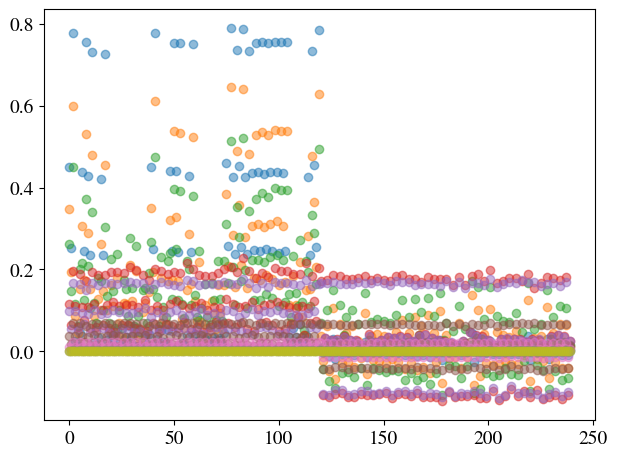

In [44]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

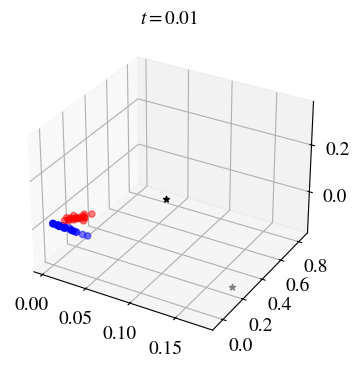

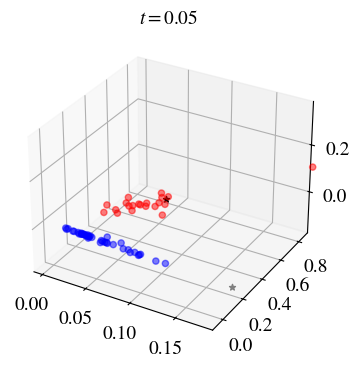

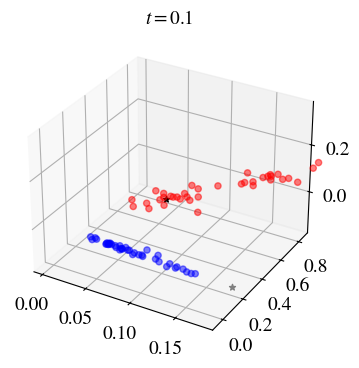

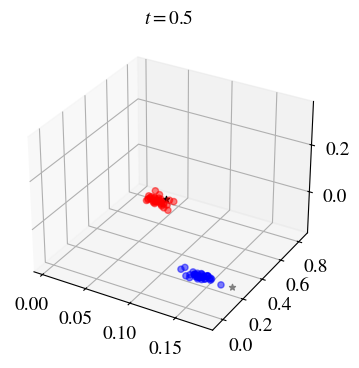

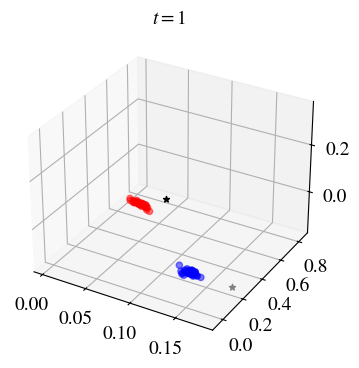

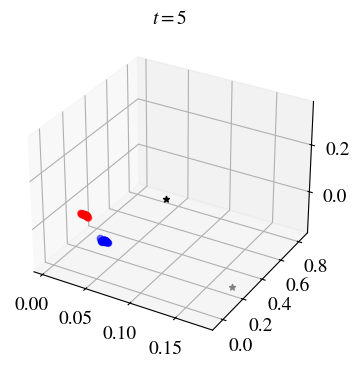

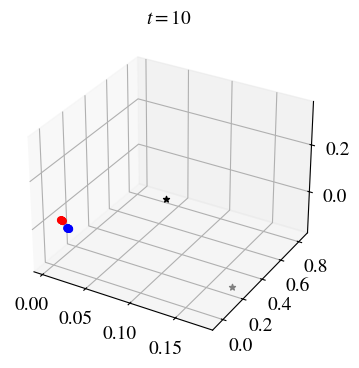

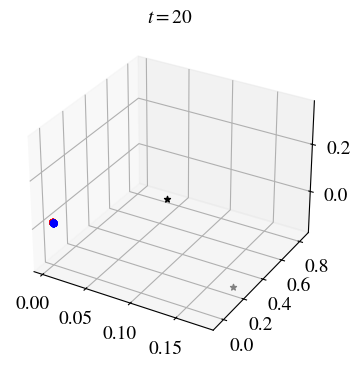

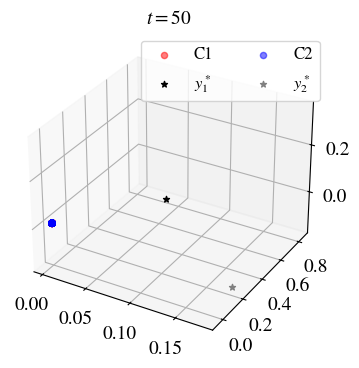

In [45]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.01, 0.19])
    ax.set_ylim([-0.1, 0.9])
    ax.set_zlim([-0.18, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=2, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
#

### n_communities = 3

In [46]:
# Parameters
n_nodes = 120
n_communities = 3
pin, pout = 0.3, 0.3

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities

In [47]:
g = nx.stochastic_block_model(block_sizes, pref_matrix, seed=0, directed=False)
A = nx.to_scipy_sparse_array(g)

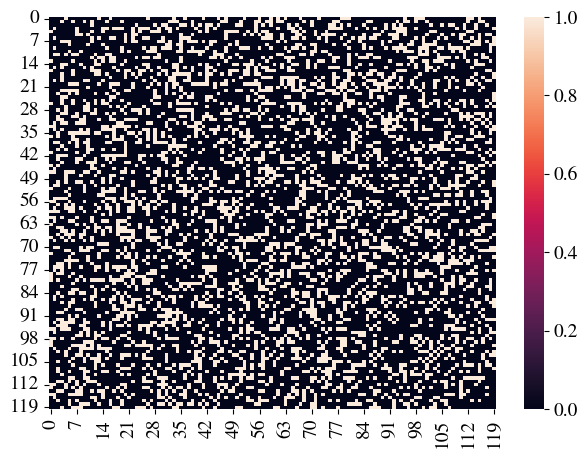

In [48]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [49]:
# Sanity check
dim = 3

R = generate_random_rotation_matrix(k=dim)
assert np.all(np.isclose(R.T @ R, np.eye(dim))), "R is not orthonormal"

planes: (1, 2), angle: 0.5855633011597872 pi
planes: (0, 1), angle: 0.030269015644767583 pi
planes: (0, 2), angle: -0.5476123123281511 pi


In [50]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [51]:
# inital characteristic vector for nodes
# s1 - choose a random position, and assign to nodes in one community
y_0_c1 = np.random.uniform(-1,1,dim)
y_0_c1 /= np.linalg.norm(y_0_c1)
print(y_0_c1)

[-0.9691513  -0.21938536 -0.11232013]


In [52]:
y_0_c2 = np.random.uniform(-1,1,dim)
y_0_c2 /= np.linalg.norm(y_0_c2)
print(y_0_c2)

[-0.74432427  0.62465893 -0.2361834 ]


In [53]:
# y_0_c3 = -y_0_c1
# y_0_c3[-int(dim/2):] = -y_0_c2[-int(dim/2):] #negate half c1 and halrf c2
# y_0_c3 /= np.linalg.norm(y_0_c3)
# print(y_0_c3)

In [54]:
# randomly assign a few nodes with nonzero characteristics at t=0
from random import sample

n_sel = [15, 20][1]
nodes_1 = sample(range(block_sizes[0]), n_sel)
nodes_2 = sample(range(block_sizes[0], block_sizes[0]+block_sizes[1]), n_sel)
# nodes_3 = sample(range(block_sizes[1], block_sizes[1]+block_sizes[2]), n_sel)

In [55]:
row = []
col = [0]*(2*n_sel*dim)
data = []
for k in nodes_1:
    for ki in range(dim):
        row.append(k*dim+ki)
        data.append(y_0_c1[ki])
for k in nodes_2:
    for ki in range(dim):
        row.append(k*dim+ki)
        data.append(y_0_c2[ki])
# for k in nodes_3:
#     for ki in range(dim):
#         row.append(k*dim+ki)
#         data.append(y_0_c3[ki])

In [56]:
from scipy.sparse import csr_array, csc_matrix
y_0 = csc_matrix((data, (row, col)), shape=(n_nodes*dim, 1))

In [57]:
# Generate a set of random rotations for each pair of communities
from scipy import sparse

src, trg, _ = sparse.find(sparse.triu(A, 1)) # only edges
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

In [58]:
noise = 0.

# intially balanced configuration
# internal edges - identity matrix
com_com_rotation_matrix = {(l, l): np.eye(dim) for l in range(n_communities)}
# external edges - first path random
com_com_rotation_matrix.update({(l, l+1): generate_random_rotation_matrix(k=dim) for l in range(n_communities-1)})
# external edges - others by existing ones
if n_communities == 2:
    com_com_rotation_matrix[(1,0)] = com_com_rotation_matrix[0,1].T
elif n_communities == 3:
    # close the cycle
    com_com_rotation_matrix[(0,2)] = com_com_rotation_matrix[(0,1)].dot(com_com_rotation_matrix[(1,2)])
    # assign others as the transpose
    for i in range(1, n_communities):
        for j in range(i):
            com_com_rotation_matrix[(i,j)] = com_com_rotation_matrix[j,i].T

planes: (0, 1), angle: -0.22638163827043378 pi
planes: (1, 2), angle: 0.2277064891136491 pi
planes: (0, 2), angle: -0.8375089108372171 pi
planes: (0, 2), angle: 0.3757266300070512 pi
planes: (0, 1), angle: -0.052562067475642626 pi
planes: (1, 2), angle: 0.42684690392164937 pi


In [59]:
coherence = 1.
# noise = 0.

In [60]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [61]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

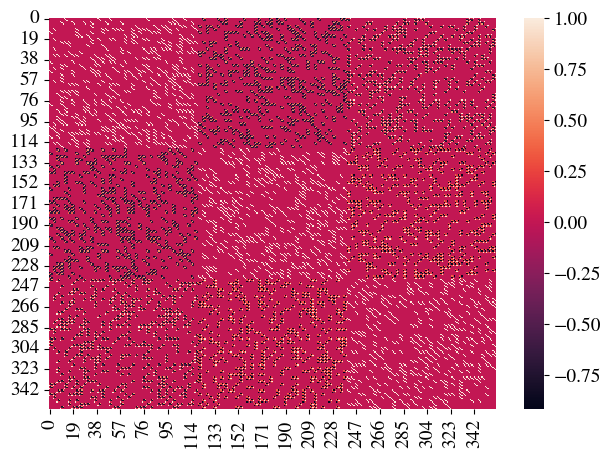

In [62]:
sns.heatmap(A_mat.todense())
plt.show()

In [63]:
# Laplacian
L_mat = D_mat - A_mat

In [64]:
# theoretical results
mat = y_0.toarray().reshape(n_nodes, dim)
y_0_bar = np.sum([assign_rotation_matrix(0, k).dot(mat[k, :]) for k in range(n_nodes)], axis=0)

y_star = []
for c in range(n_communities):
    y_star.append(com_com_rotation_matrix[(0, c)].T.dot(y_0_bar)/n_nodes)
# y_1 = com_com_rotation_matrix[(0, 0)].dot(y_0_bar)/n_nodes
# y_2 = com_com_rotation_matrix[(0, 1)].T.dot(y_0_bar)/n_nodes
print("C1:", y_star[0])
print("C2:", y_star[1])
print("C3:", y_star[2])

C1: [-0.10211185  0.10991559 -0.07155459]
C2: [ 0.03445419  0.15006396 -0.06262622]
C3: [-0.13370563 -0.02076711 -0.09653941]


In [65]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01]
# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

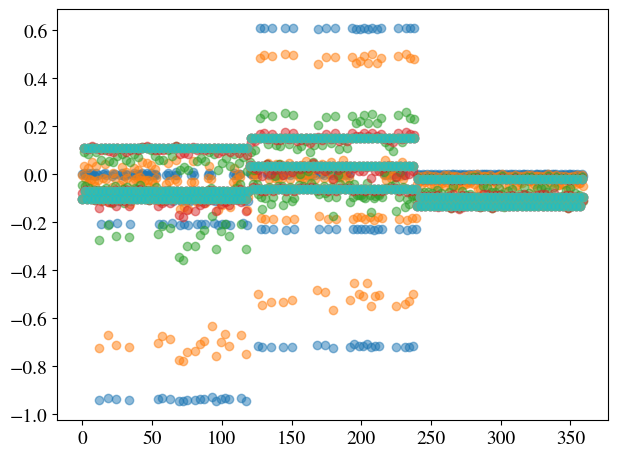

In [66]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

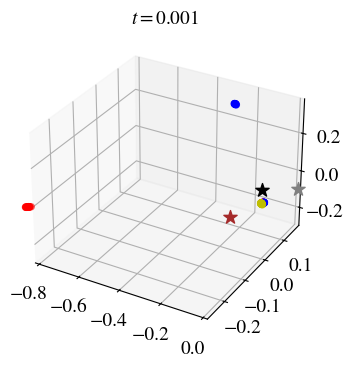

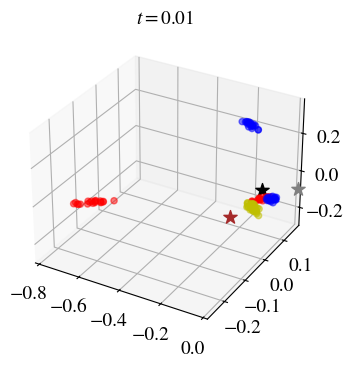

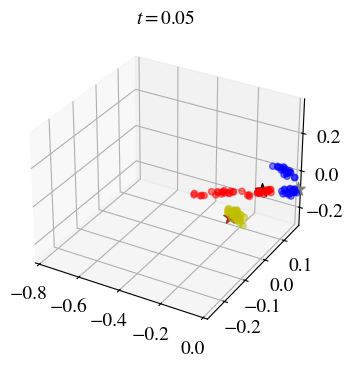

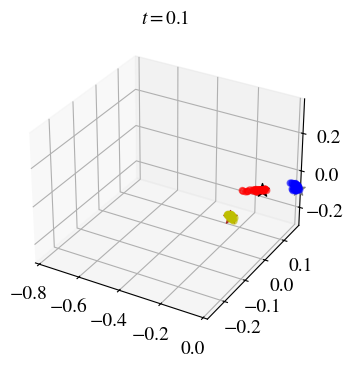

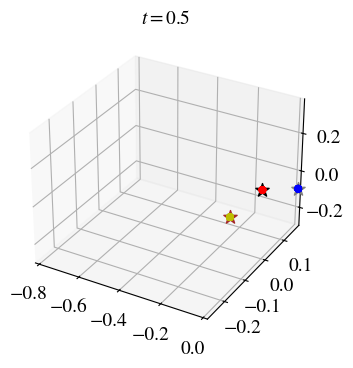

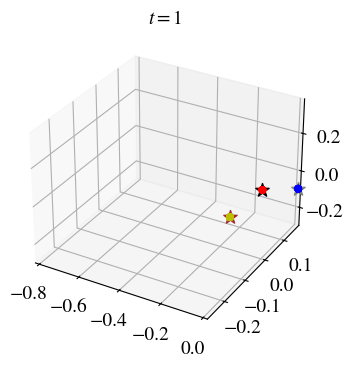

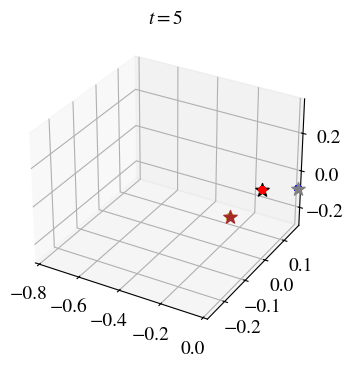

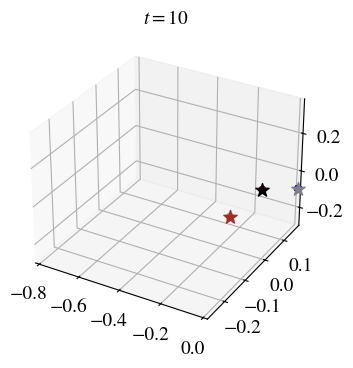

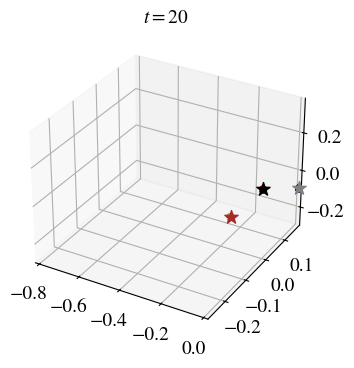

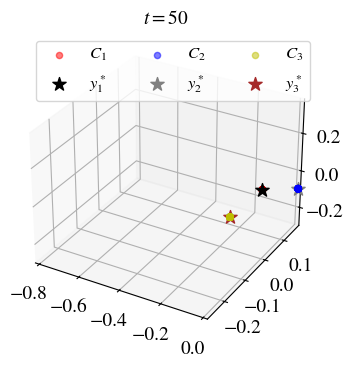

In [67]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', s=100, color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.82, 0.02])
    ax.set_ylim([-0.28, 0.18])
    ax.set_zlim([-0.3, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
#

#### Adding some noise

In [68]:
coherence = .8
noise = 0.1

In [69]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 1), noise angle: -0.11637709037932598 pi
planes: (0, 2), noise angle: 0.08568759092053364 pi
planes: (1, 2), noise angle: -0.032680588342767644 pi
planes: (0, 1), noise angle: 0.11151080815331674 pi
planes: (0, 2), noise angle: 0.09073238746809975 pi
planes: (1, 2), noise angle: 0.0859343443153956 pi
planes: (1, 2), noise angle: -0.1398595416589697 pi
planes: (0, 2), noise angle: 0.09107156323662108 pi
planes: (0, 1), noise angle: -0.18967489798498643 pi
planes: (0, 1), noise angle: -0.056771143628228604 pi
planes: (1, 2), noise angle: 0.024255981268711962 pi
planes: (0, 2), noise angle: -0.12140683906307384 pi
planes: (1, 2), noise angle: -0.005065676478515562 pi
planes: (0, 1), noise angle: 0.0386320138092963 pi
planes: (0, 2), noise angle: 0.19192049238980535 pi
planes: (1, 2), noise angle: -0.11777112111432582 pi
planes: (0, 1), noise angle: -0.0813321193077259 pi
planes: (0, 2), noise angle: -0.032134189431469104 pi
planes: (0, 1), noise angle: -0.14368631476555047 pi


In [70]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

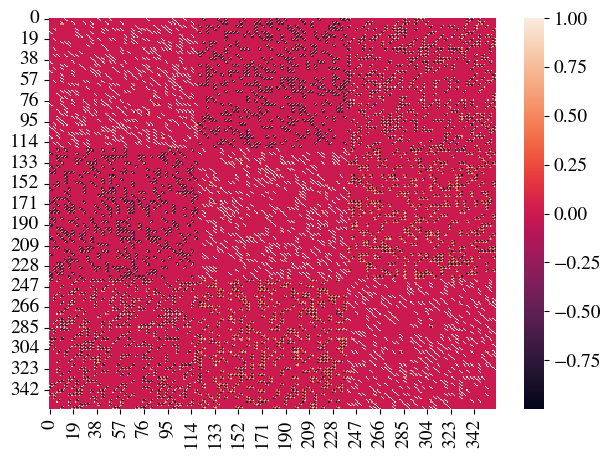

In [71]:
sns.heatmap(A_mat.todense())
plt.show()

In [72]:
# Laplacian
L_mat = D_mat - A_mat

In [73]:
# consensus dynamics
from scipy.sparse.linalg import expm

ts = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

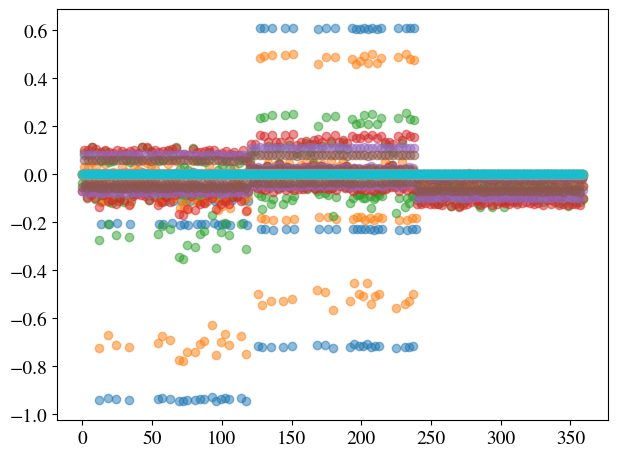

In [74]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

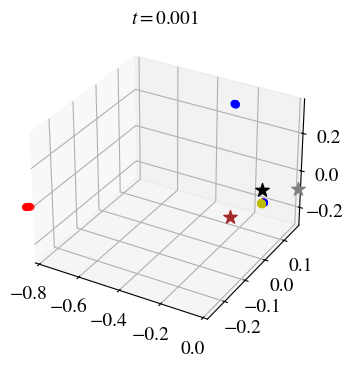

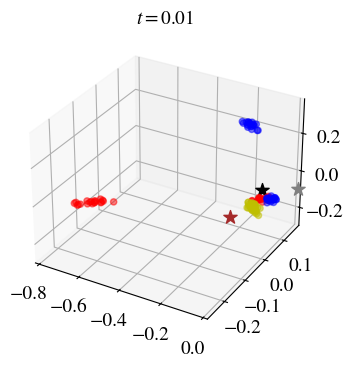

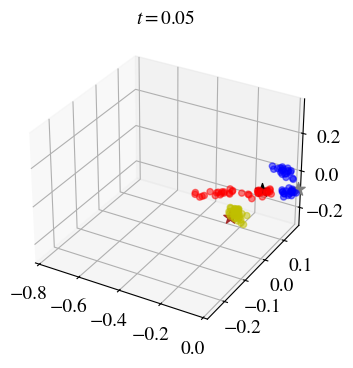

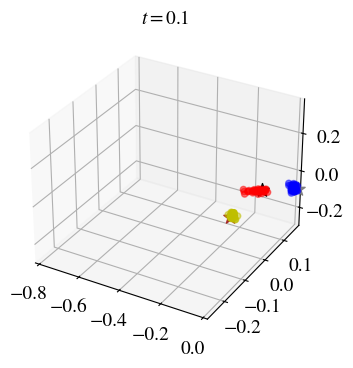

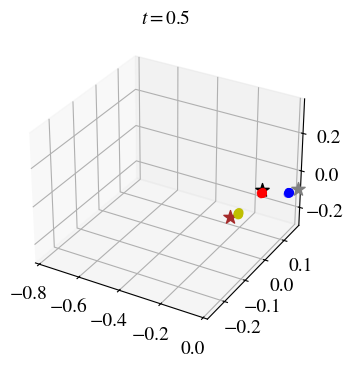

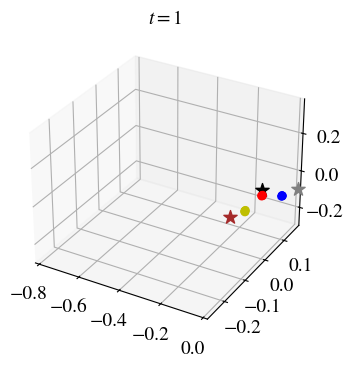

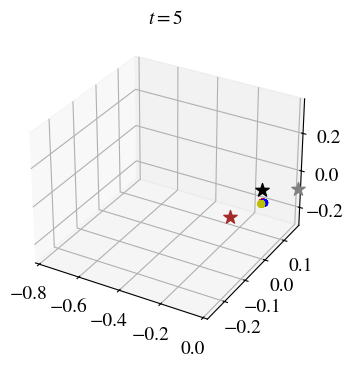

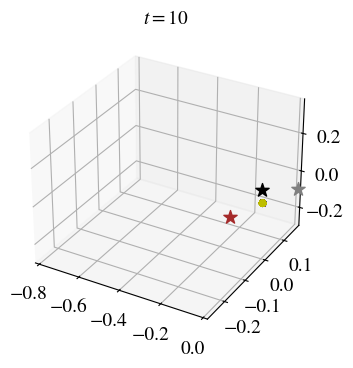

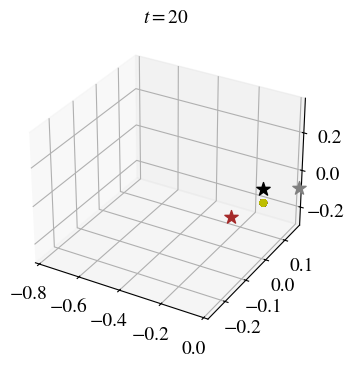

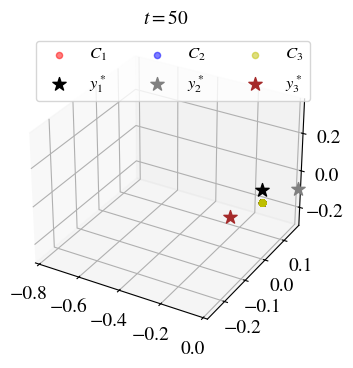

In [75]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', s=100, color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.82, 0.02])
    ax.set_ylim([-0.28, 0.18])
    ax.set_zlim([-0.3, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
#

#### Reducing p_out

In [76]:
# randomly remove edges from g
pout2 = [0.1, 0.03, 0.01][0]
pcut = (pout - pout2)/pout
print("edges to cut:", pcut)

edges to cut: 0.6666666666666666


In [77]:
g2 = g.copy()
edges_out = [(k,l) for k,l in zip(src, trg) if membership[k] != membership[l]]
print("#edges out:", len(edges_out))
n_cut = int(len(edges_out)*pcut)
print("#edges to cut", n_cut)

#edges out: 1432
#edges to cut 954


In [78]:
from random import sample

ind_cut = sample(range(len(edges_out)), n_cut)
edges_cut = [edges_out[k] for k in ind_cut]
g2.remove_edges_from(edges_cut)

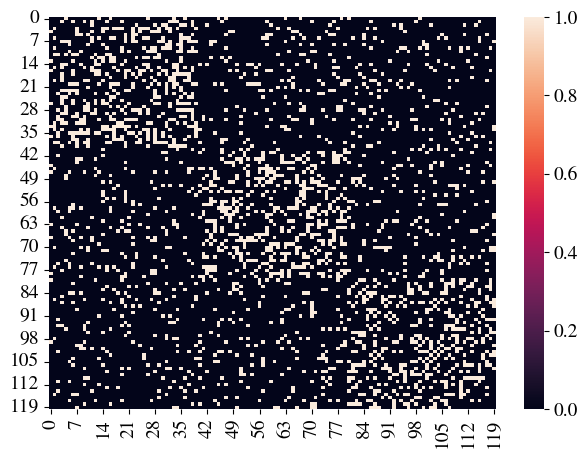

In [79]:
A2 = nx.to_scipy_sparse_array(g2)
sns.heatmap(A2.todense())
plt.show()

In [80]:
# degree matrix
from scipy.sparse import diags

d = A2.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [81]:
src2, trg2, _ = sparse.find(sparse.triu(A, 1)) # only edges

In [82]:
coherence = .8
noise = 0.1

In [83]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src2, trg2):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 2), noise angle: -0.07804127226545728 pi
planes: (0, 1), noise angle: 0.10790395751327736 pi
planes: (1, 2), noise angle: -0.00021542610741776504 pi
planes: (1, 2), noise angle: -0.11313264003812587 pi
planes: (0, 1), noise angle: -0.052868985331076125 pi
planes: (0, 2), noise angle: -0.04846501965829711 pi
planes: (0, 2), noise angle: 0.021822161878543075 pi
planes: (1, 2), noise angle: -0.07336138870297378 pi
planes: (0, 1), noise angle: 0.1260307931732658 pi
planes: (0, 2), noise angle: -0.08019031172766852 pi
planes: (1, 2), noise angle: -0.028333878017193732 pi
planes: (0, 1), noise angle: 0.03257273198569296 pi
planes: (1, 2), noise angle: -0.022413583554275654 pi
planes: (0, 2), noise angle: -0.13786652460346407 pi
planes: (0, 1), noise angle: 0.07123613077641981 pi
planes: (0, 1), noise angle: -0.17769719591824523 pi
planes: (0, 2), noise angle: -0.032265742371760296 pi
planes: (1, 2), noise angle: 0.04259629466450837 pi
planes: (0, 1), noise angle: -0.0612696977069

In [84]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

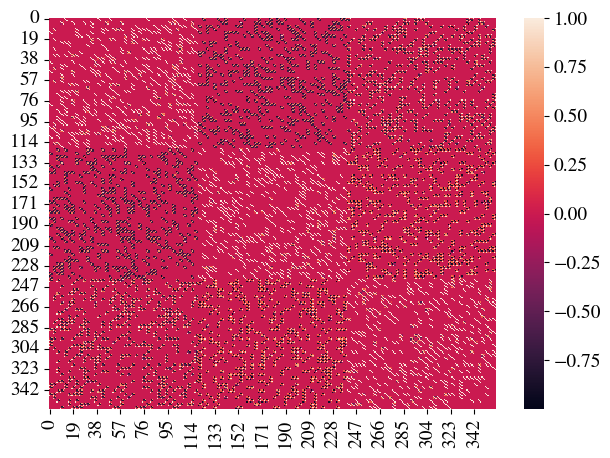

In [85]:
sns.heatmap(A_mat.todense())
plt.show()

In [86]:
# Laplacian
L_mat = D_mat - A_mat

In [87]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
# ts = np.arange(1.6, 3., 0.1)
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

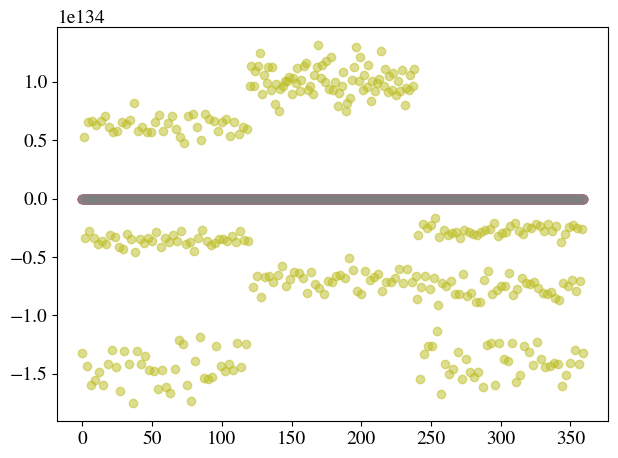

In [88]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

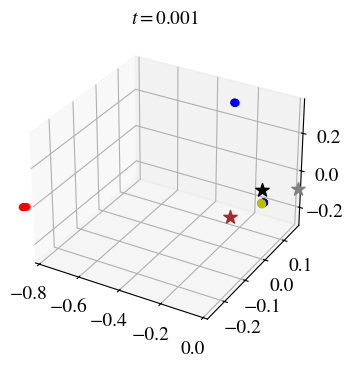

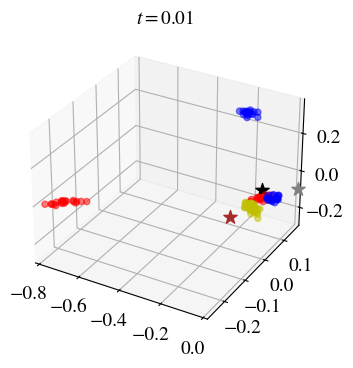

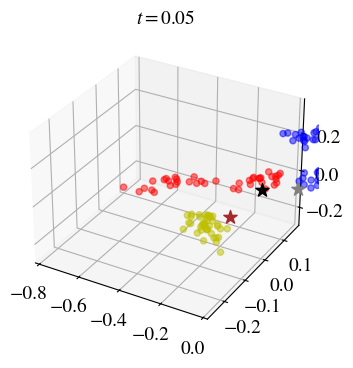

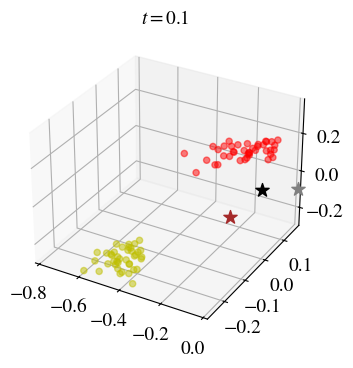

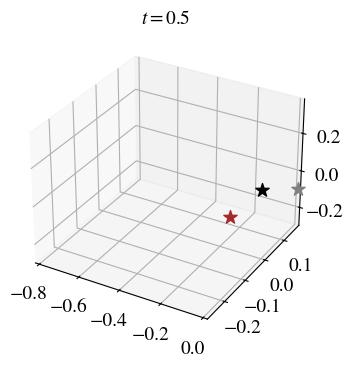

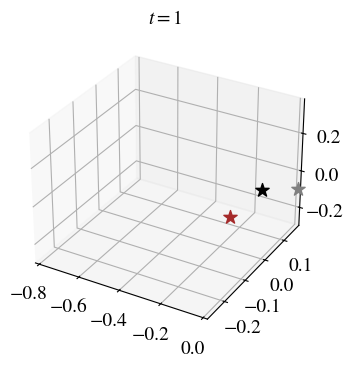

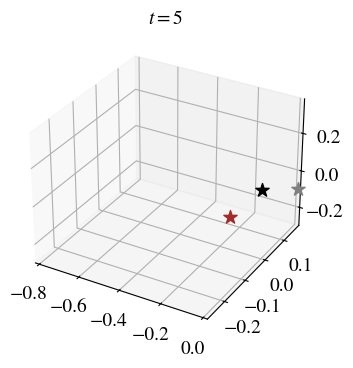

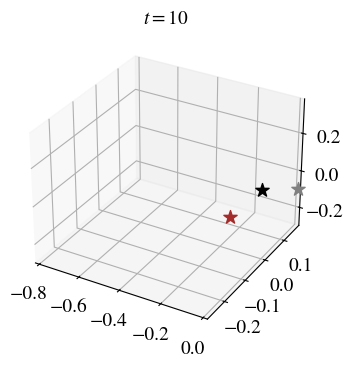

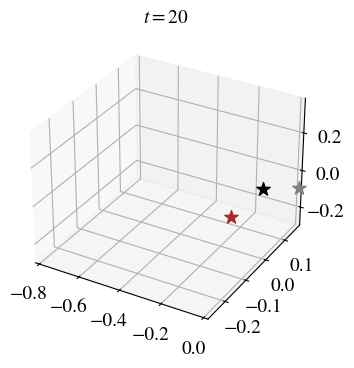

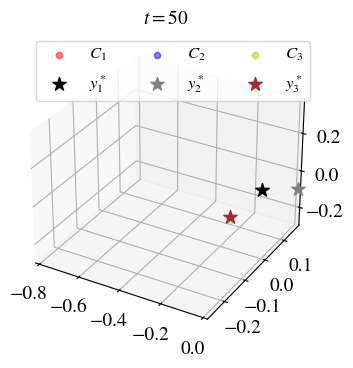

In [89]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(1):
# for t in range(len(ts)-1, len(ts)):
for t in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2], color=colors[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], y_star[c][2], marker='*', s=100, color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    ax.set_xlim([-0.82, 0.02])
    ax.set_ylim([-0.28, 0.18])
    ax.set_zlim([-0.3, 0.38])
    if t == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout2, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()
#

## Random walks

### n_communities = 3

In [90]:
# Parameters
n_nodes = 120
n_communities = 3
pin, pout = 0.3, 0.3

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities

In [91]:
g = nx.stochastic_block_model(block_sizes, pref_matrix, seed=0, directed=False)
A = nx.to_scipy_sparse_array(g)

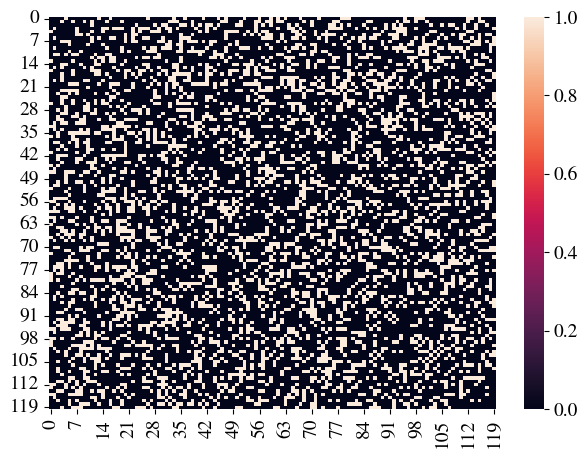

In [92]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [93]:
src, trg, _ = sparse.find(sparse.triu(A, 1)) # only edges
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

In [94]:
# let's maintain the same rotation matrices as before
coherence = 1.
noise = 0.

In [95]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [96]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

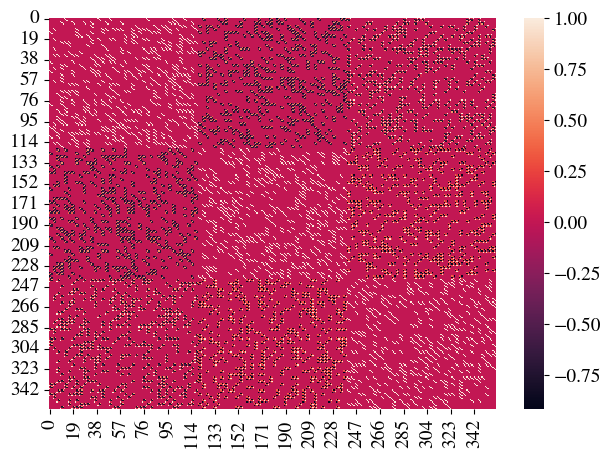

In [97]:
sns.heatmap(A_mat.todense())
plt.show()

In [98]:
d = A.sum(axis=1)
d2 = np.repeat(d, dim).astype(float)
Dinv_mat = diags(1/d2, 0, format='csc')

In [140]:
# matrix transition matrix
P_mat = Dinv_mat @ A_mat

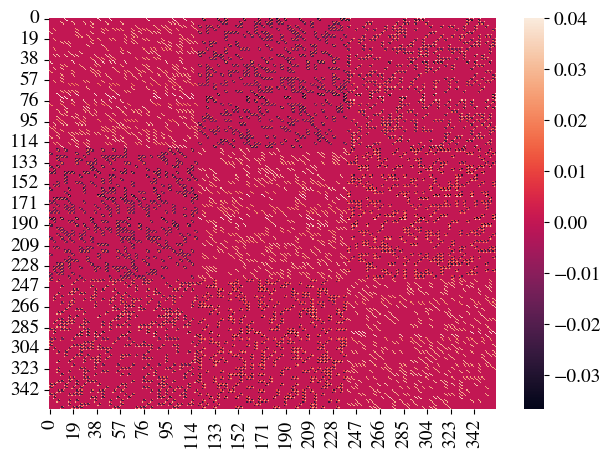

In [100]:
sns.heatmap(P_mat.todense())
plt.show()

In [101]:
# theoretical results
n_edges = g.number_of_edges()
mat = y_0.toarray().reshape(n_nodes, dim)
y_0_bar = np.sum([assign_rotation_matrix(0, k).dot(mat[k, :]) for k in range(n_nodes)], axis=0)

y_star = []
for c in range(n_communities):
    y_star.append(com_com_rotation_matrix[(0, c)].T.dot(y_0_bar)/(2*n_edges)) # ignoring the degree
# y_1 = com_com_rotation_matrix[(0, 0)].dot(y_0_bar)/n_nodes
# y_2 = com_com_rotation_matrix[(0, 1)].T.dot(y_0_bar)/n_nodes
print("C1:", y_star[0])
print("C2:", y_star[1])
print("C3:", y_star[2])

C1: [-0.00291609  0.00313895 -0.00204344]
C2: [ 0.00098394  0.0042855  -0.00178847]
C3: [-0.00381834 -0.00059306 -0.00275696]


In [102]:
# random walk dynamics
from scipy.sparse.linalg import expm

ts_all = np.arange(500)
res = [y_0]

y_tT = y_0.T
for t in ts_all:
    y_tT = y_tT @ P_mat
    res.append(y_tT.T)
#     plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)

In [138]:
y_0.data

array([-0.9691513 , -0.21938536, -0.11232013, -0.9691513 , -0.21938536,
       -0.11232013, -0.9691513 , -0.21938536, -0.11232013, -0.9691513 ,
       -0.21938536, -0.11232013, -0.9691513 , -0.21938536, -0.11232013,
       -0.9691513 , -0.21938536, -0.11232013, -0.9691513 , -0.21938536,
       -0.11232013, -0.9691513 , -0.21938536, -0.11232013, -0.9691513 ,
       -0.21938536, -0.11232013, -0.9691513 , -0.21938536, -0.11232013,
       -0.9691513 , -0.21938536, -0.11232013, -0.9691513 , -0.21938536,
       -0.11232013, -0.9691513 , -0.21938536, -0.11232013, -0.9691513 ,
       -0.21938536, -0.11232013, -0.9691513 , -0.21938536, -0.11232013,
       -0.9691513 , -0.21938536, -0.11232013, -0.9691513 , -0.21938536,
       -0.11232013, -0.9691513 , -0.21938536, -0.11232013, -0.9691513 ,
       -0.21938536, -0.11232013, -0.9691513 , -0.21938536, -0.11232013,
       -0.74432427,  0.62465893, -0.2361834 , -0.74432427,  0.62465893,
       -0.2361834 , -0.74432427,  0.62465893, -0.2361834 , -0.74

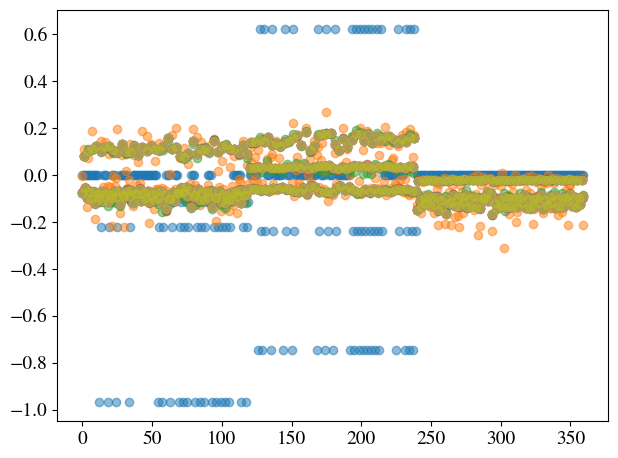

In [103]:
# output the results
# ts = [0, 1, 2, 3, 50]
ts = [0, 1, 2, 3, 5, 10, 50, 100, 500]

for t in ts:
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

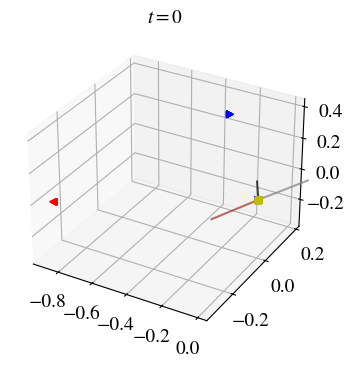

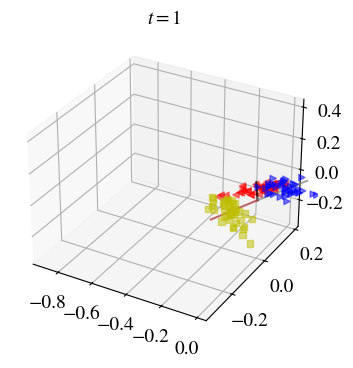

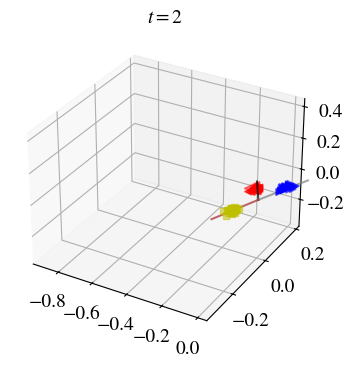

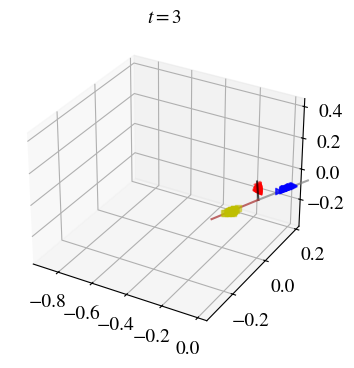

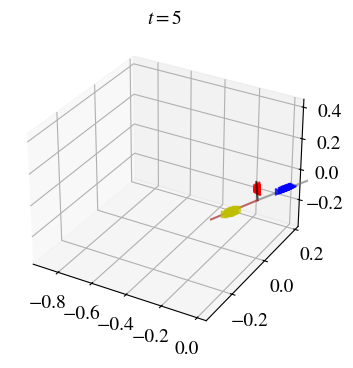

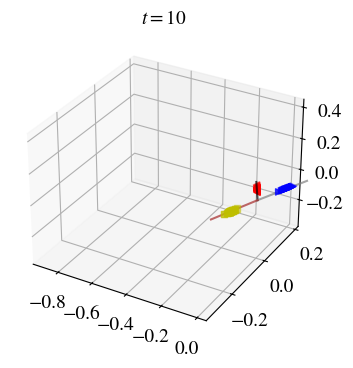

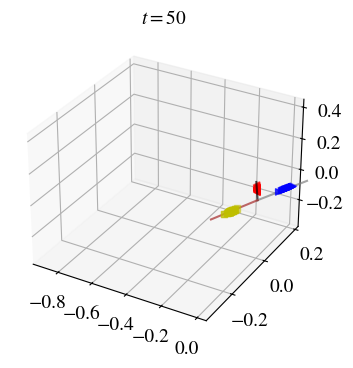

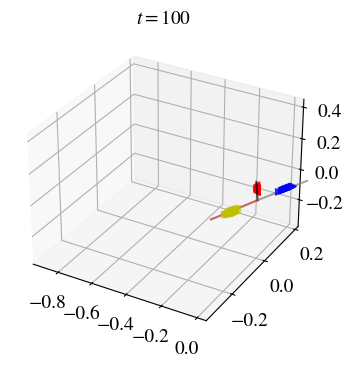

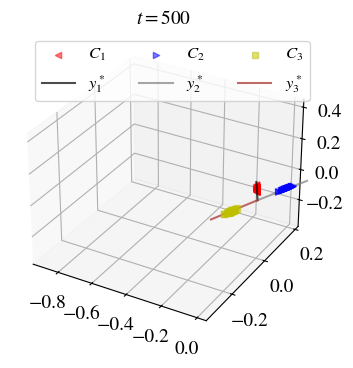

In [104]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
fac = 60
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']
markers = ['<', '>', 's']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(2):
# for ti in range(len(ts)-5, len(ts)):
for ti in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    t = ts[ti]
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2],
                   color=colors[c], marker=markers[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.plot3D([0, y_star[c][0]*fac],
                  [0, y_star[c][1]*fac],
                  [0, y_star[c][2]*fac],
                  color=colors_m[c], label=r'$y_{}^*$'.format(c+1), alpha=0.7)
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(t))
    ax.set_xlim([-0.95, 0.05])
    ax.set_ylim([-0.35, 0.22])
    ax.set_zlim([-0.38, 0.45])
    if ti == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('rw-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, ti), dpi=300, bbox_inches='tight')
    plt.show()
#

#### Add some noise

In [105]:
coherence = .8
noise = 0.1

In [106]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 1), noise angle: 0.19439664396833373 pi
planes: (1, 2), noise angle: 0.15246340074616788 pi
planes: (0, 2), noise angle: -0.06442083286440745 pi
planes: (1, 2), noise angle: -0.07349558189241166 pi
planes: (0, 1), noise angle: -0.1388426901396956 pi
planes: (0, 2), noise angle: 0.11217914287730531 pi
planes: (0, 2), noise angle: -0.03812184096862006 pi
planes: (1, 2), noise angle: -0.03761601183436382 pi
planes: (0, 1), noise angle: -0.01576434401128372 pi
planes: (1, 2), noise angle: 0.008937497713423656 pi
planes: (0, 1), noise angle: -0.15290754081504987 pi
planes: (0, 2), noise angle: -0.12235863171913018 pi
planes: (1, 2), noise angle: -0.14844982273104337 pi
planes: (0, 1), noise angle: -0.02054262095568204 pi
planes: (0, 2), noise angle: -0.011985539440254189 pi
planes: (0, 1), noise angle: 0.04137207508465044 pi
planes: (0, 2), noise angle: 0.05734528126098237 pi
planes: (1, 2), noise angle: -0.06274264998020444 pi
planes: (0, 2), noise angle: -0.058763442080980305 

In [107]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

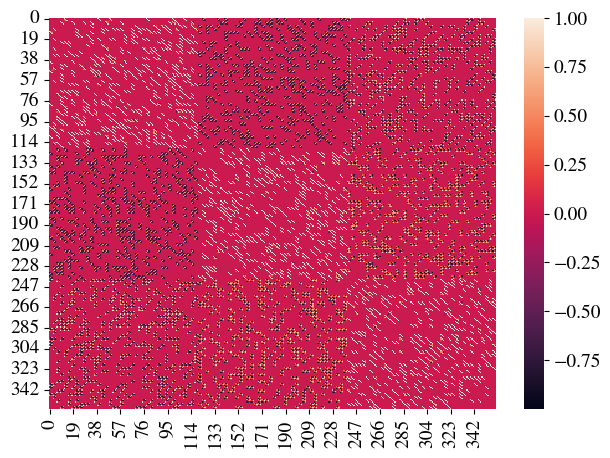

In [108]:
sns.heatmap(A_mat.todense())
plt.show()

In [109]:
d = A.sum(axis=1)
d2 = np.repeat(d, dim).astype(float)
Dinv_mat = diags(1/d2, 0, format='csc')

In [110]:
# matrix transition matrix
P_mat = Dinv_mat @ A_mat

In [111]:
from scipy.sparse.linalg import eigs
vals, vecs = eigs(P_mat, k=12)
print(vals)

[ 0.97964547+0.j  0.98163636+0.j  0.98294076+0.j  0.27348297+0.j
  0.27227248+0.j  0.270751  +0.j -0.28509785+0.j -0.28361352+0.j
 -0.28328673+0.j -0.27132486+0.j -0.26971832+0.j -0.27060659+0.j]


In [112]:
# random walk dynamics
from scipy.sparse.linalg import expm

ts_all = np.arange(500)
res = [y_0]

y_tT = y_0.T
for t in ts_all:
    y_tT = y_tT @ P_mat
    res.append(y_tT.T)
#     plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)

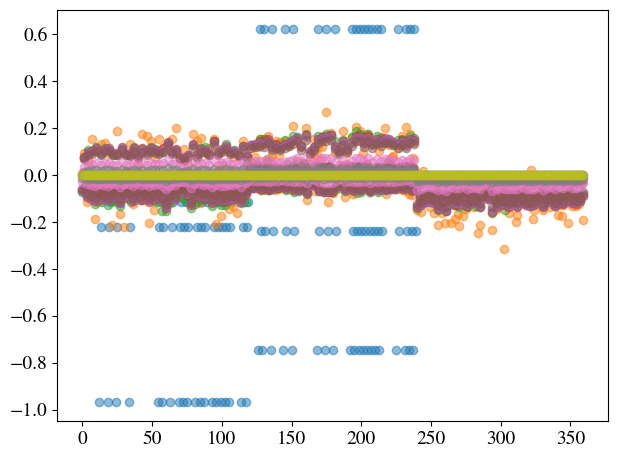

In [113]:
# output the results
ts = [0, 1, 2, 3, 5, 10, 50, 100, 500]
for t in ts:
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

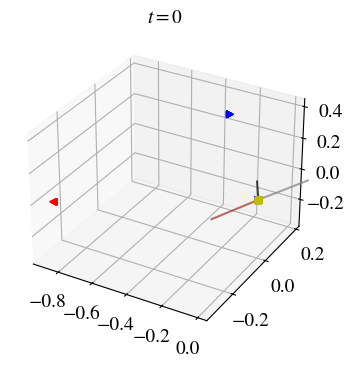

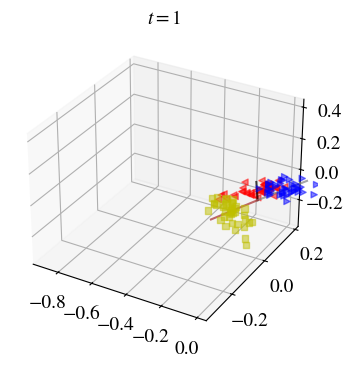

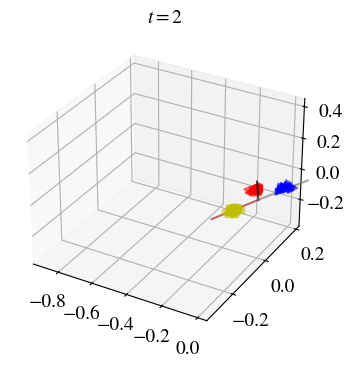

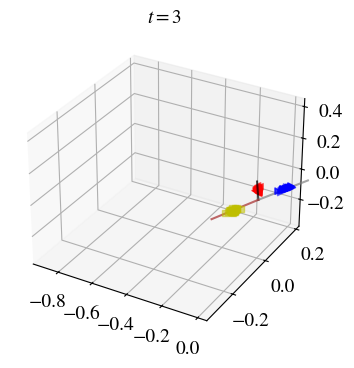

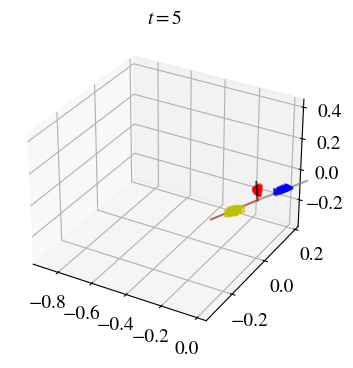

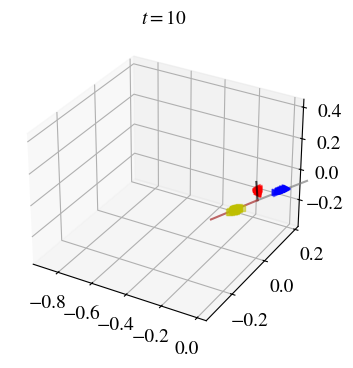

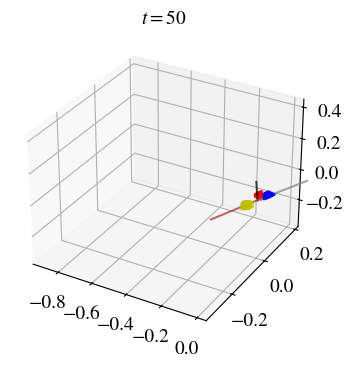

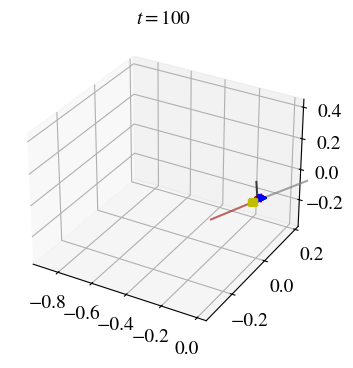

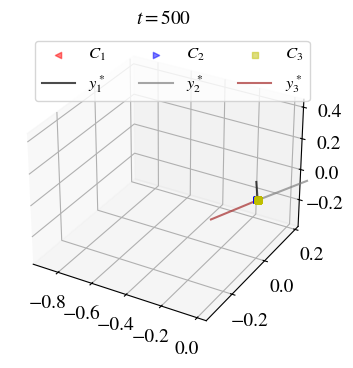

In [114]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
fac = 60
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']
markers = ['<', '>', 's']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(2):
# for ti in range(len(ts)-5, len(ts)):
for ti in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    t = ts[ti]
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2],
                   color=colors[c], marker=markers[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.plot3D([0, y_star[c][0]*fac],
                  [0, y_star[c][1]*fac],
                  [0, y_star[c][2]*fac],
                  color=colors_m[c], label=r'$y_{}^*$'.format(c+1), alpha=0.7)
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(t))
    ax.set_xlim([-0.95, 0.05])
    ax.set_ylim([-0.35, 0.22])
    ax.set_zlim([-0.38, 0.45])
    if ti == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('rw-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, ti), dpi=300, bbox_inches='tight')
    plt.show()
#

#### reducing p_out

In [115]:
# randomly remove edges from g
pout2 = [0.1, 0.03, 0.01][1]
pcut = (pout - pout2)/pout
print("edges to cut:", pcut)

edges to cut: 0.9000000000000001


In [116]:
g2 = g.copy()
edges_out = [(k,l) for k,l in zip(src, trg) if membership[k] != membership[l]]
print("#edges out:", len(edges_out))
n_cut = int(len(edges_out)*pcut)
print("#edges to cut", n_cut)

#edges out: 1432
#edges to cut 1288


In [117]:
from random import sample

ind_cut = sample(range(len(edges_out)), n_cut)
edges_cut = [edges_out[k] for k in ind_cut]
g2.remove_edges_from(edges_cut)

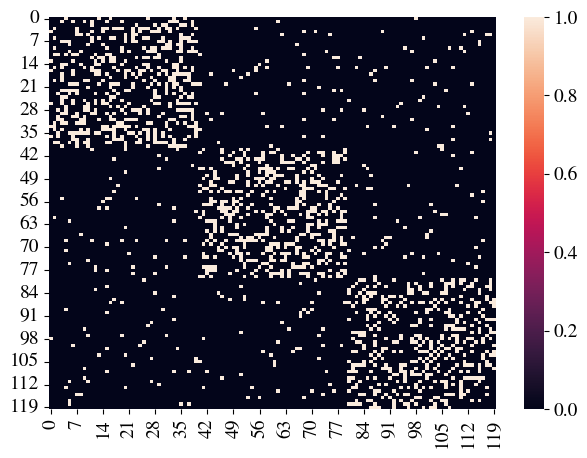

In [118]:
A2 = nx.to_scipy_sparse_array(g2)
sns.heatmap(A2.todense())
plt.show()

In [119]:
# degree matrix
from scipy.sparse import diags

d = A2.sum(axis=1)
d2 = np.repeat(d, dim).astype(float)
Dinv_mat = diags(1/d2, 0, format='csc')

In [120]:
src2, trg2, _ = sparse.find(sparse.triu(A2, 1)) # only edges

In [121]:
coherence = .8
noise = 0.1

In [122]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src2, trg2):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

planes: (0, 1), noise angle: -0.011222289650345435 pi
planes: (0, 2), noise angle: -0.1761114864271141 pi
planes: (1, 2), noise angle: 0.00018440698606696278 pi
planes: (1, 2), noise angle: -0.13725221948983257 pi
planes: (0, 1), noise angle: -0.064946653058638 pi
planes: (0, 2), noise angle: -0.18423548765852604 pi
planes: (0, 2), noise angle: 0.1646733012268784 pi
planes: (1, 2), noise angle: 0.09374222803098577 pi
planes: (0, 1), noise angle: 0.0005620796597774939 pi
planes: (0, 1), noise angle: -0.10827515443984703 pi
planes: (0, 2), noise angle: -0.09158077819321295 pi
planes: (1, 2), noise angle: 0.24094180586884104 pi
planes: (0, 2), noise angle: 0.08388530094541384 pi
planes: (1, 2), noise angle: -0.2783777784503941 pi
planes: (0, 1), noise angle: -0.008299838901933239 pi
planes: (0, 1), noise angle: 0.08980153277069286 pi
planes: (0, 2), noise angle: 0.14538803597106223 pi
planes: (1, 2), noise angle: -0.08669214586905255 pi
planes: (1, 2), noise angle: -0.08166815961305307 pi

In [123]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

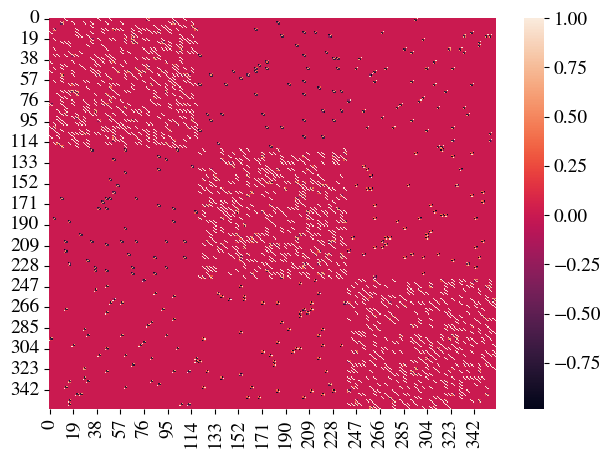

In [124]:
sns.heatmap(A_mat.todense())
plt.show()

In [125]:
# matrix transition matrix
P_mat = Dinv_mat @ A_mat

In [126]:
from scipy.sparse.linalg import eigs
vals, vecs = eigs(P_mat, k=12)
print(vals)

[ 0.98775918+0.j  0.98554991+0.j  0.98539168+0.j  0.7710604 +0.j
  0.76717557+0.j  0.76837375+0.j  0.75309884+0.j  0.75012077+0.j
  0.75156196+0.j -0.47232709+0.j -0.4702401 +0.j -0.46849464+0.j]


In [127]:
# random walk dynamics
from scipy.sparse.linalg import expm

ts_all = np.arange(500)
res = [y_0]

y_tT = y_0.T
for t in ts_all:
    y_tT = y_tT @ P_mat
    res.append(y_tT.T)
#     plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)

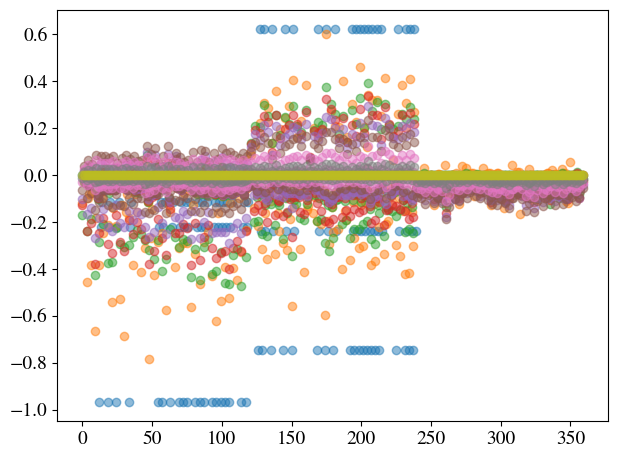

In [128]:
# output the results
ts = [0, 1, 2, 3, 5, 10, 50, 100, 500]
for t in ts:
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

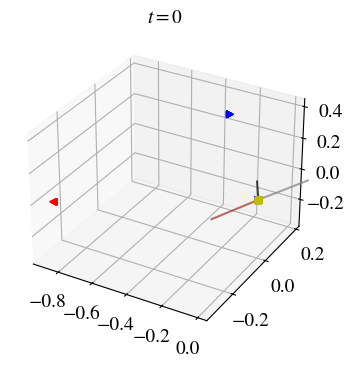

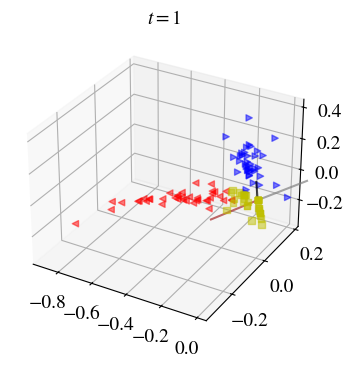

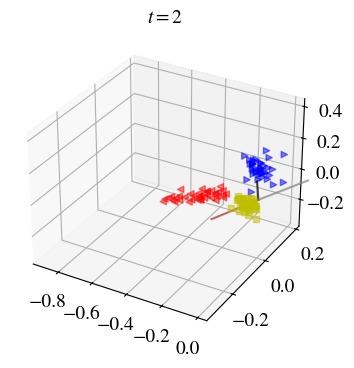

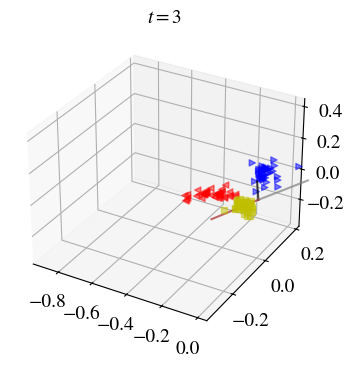

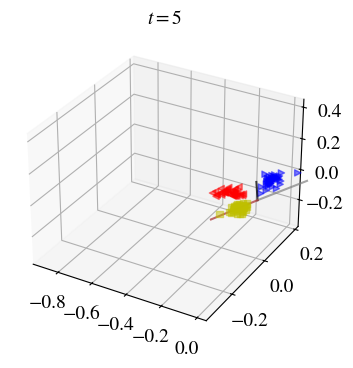

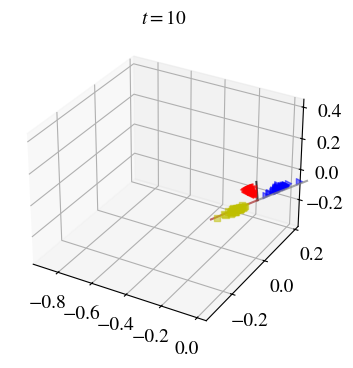

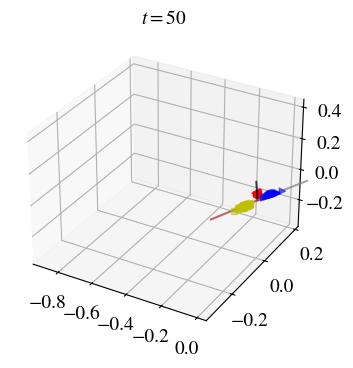

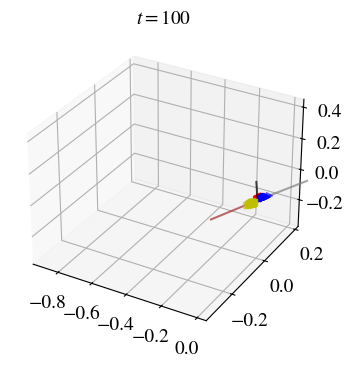

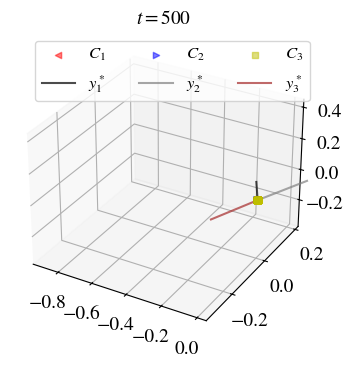

In [129]:
# scatter plot of each community
# figsize = (3.6, 2.6)
figsize = (3.9, 3.9)
fac = 60
alpha = 0.5
colors = ['r', 'b', 'y']
colors_m = ['k', 'grey', 'brown']
labels = ['C1', 'C2', 'C3']
markers = ['<', '>', 's']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

# for t in range(2):
# for ti in range(len(ts)-5, len(ts)):
for ti in range(len(ts)):
#     fig, ax = plt.subplots(figsize=figsize)
    fig = plt.figure(figsize=figsize)
    ax = plt.axes(projection='3d')
    ax.grid()

    t = ts[ti]
    mat = res[t].toarray().reshape(n_nodes, dim)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], mat[ci:ci+block_sizes[c], 2],
                   color=colors[c], marker=markers[c], label=r'$C_{}$'.format(c+1), alpha=alpha)
        ax.plot3D([0, y_star[c][0]*fac],
                  [0, y_star[c][1]*fac],
                  [0, y_star[c][2]*fac],
                  color=colors_m[c], label=r'$y_{}^*$'.format(c+1), alpha=0.7)
        ci += block_sizes[c]

    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(t))
    ax.set_xlim([-0.95, 0.05])
    ax.set_ylim([-0.35, 0.22])
    ax.set_zlim([-0.38, 0.45])
    if ti == len(ts)-1:
        plt.legend(loc='upper right', ncol=n_communities, fontsize=fz-2)
    plt.savefig('rw-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout2, coherence, ti), dpi=300, bbox_inches='tight')
    plt.show()
#